In [64]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [142]:
#np.random.seed(6)

(X_train, Y_train), (x_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
#X_train, X_test = X_train.reshape((784,)), x_test.reshape((784,))  # flatten data
#X_train = X_train.reshape(X_train.shape[0], 1, 28 * 28)
X_train, Y_train = shuffle(X_train, Y_train)
X_train = X_train.reshape(X_train.shape[0], -1)
print("")

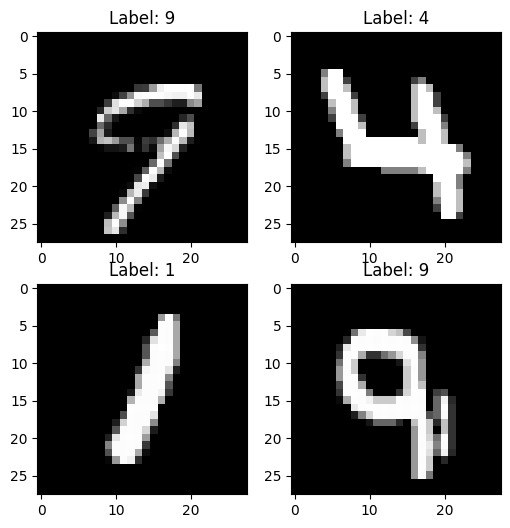

In [130]:
# must run previous cell block first before running this one again
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%Y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

Y_train = to_categorical(Y_train, num_classes=10)
Y_train = Y_train.reshape(Y_train.shape[0], 10, 1)
y_val = to_categorical(Y_train, num_classes=10)
y_test = to_categorical(Y_train, num_classes=10)

In [121]:
seed = 42
low = -0.5
high = 0.5

rng = np.random.uniform(low, high, (784, 10))
print(str(rng.shape))
#rng.uniform(low, high, 784)


(784, 10)


In [131]:
class Model():  
    def __init__(self, layers, epochs = 50):
        self.layers = layers
        self.epochs = epochs

    def forward_propagate(self, input_data):
        output_layer1 = self.layers[0].forward_propagate(input_data)
        activated_output_layer1 = self.relu(output_layer1)
        output_layer2 = self.layers[1].forward_propagate(activated_output_layer1)
        activated_output_layer2 = self.softmax(output_layer2)
        return activated_output_layer2

    def relu(self, x):
        return np.maximum(0, x)

    def d_relu(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, input):
        e = np.exp(input - input.max(axis=0, keepdims=True))
        return e / e.sum(axis=0, keepdims=True)
    
    def mse_loss(self, y_true, y_pred):
        diff = y_true - y_pred
        return np.mean(diff**2)
    
    def mse_loss_grad(self, y_true, y_pred):
        return 2*(y_pred-y_true)/y_pred.shape[1]
    
    def backward_propagate(self, output):
        output_layer1 = self.layers[1].backward_propagate(output)
        output_layer2 = self.layers[0].backward_propagate(output_layer1)
        return output_layer2

    
    def train(self, X_train, Y_train):
        for epoch in range(0, self.epochs):
            total_loss = 0
            for x, y in zip(X_train, Y_train.T):
                y_pred = self.forward_propagate(x.T)

                loss = self.mse_loss(y, y_pred)
                total_loss += loss
                
                gradient = self.mse_loss_grad(y, y_pred)
                gradient = self.backward_propagate(gradient)
                
            if epoch % 10 == 0:
                print("Epoch", epoch + 1, "out of", len(self.epochs), "loss:", total_loss / len(X_train))

In [184]:
class Model():  
    def __init__(self, layers, epochs = 50):
        self.layers = layers
        self.epochs = epochs
        self.input = None

    def forward_propagate(self, input_data):
        output_layer1 = self.layers[0].forward_propagate(input_data)
        activated_output_layer1 = self.relu(output_layer1)
        output_layer2 = self.layers[1].forward_propagate(activated_output_layer1)
        activated_output_layer2 = self.softmax(output_layer2)
        return activated_output_layer2

    def relu(self, x):
        return np.maximum(0, x)

    def d_relu(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, input):
        e = np.exp(input - input.max(axis=0, keepdims=True))
        return e / e.sum(axis=0, keepdims=True)
    
    def mse_loss(self, y_true, y_pred):
        diff = y_true - y_pred
        return np.mean(diff**2)

    def mse_loss_grad(self, y_true, y_pred):
        return 2*(y_pred-y_true)/y_pred.shape[1]

    def backward_propagate(self, y_true, y_pred, learning_rate=0.01):
        bprop_input_value = self.mse_loss_grad(y_true, y_pred)
        for layer in reversed(self.layers):
            bprop_input_value = layer.backward_propagate(bprop_input_value, learning_rate)
        return bprop_input_value

    def train(self, X_train, Y_train):
        assert len(X_train) == len(Y_train), "Length of X_train and Y_train should be equal!"
        for epoch in range(self.epochs):
            total_loss = 0
            for x, y in zip(X_train, Y_train):
                x = x.reshape(1, x.shape[0])
                y_pred = self.forward_propagate(x)
                loss = self.mse_loss(y, y_pred)
                total_loss += loss
                self.backward_propagate(y, y_pred)
            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1} out of {self.epochs}, loss: {total_loss / len(X_train)}")


class Dense():
    def __init__(self, m_input_size, n_output_size):
        self.input_size = m_input_size
        self.output_size = n_output_size
        self.input = None
        self.weights = np.random.uniform(-0.5, 0.5, (self.input_size, self.output_size))
        self.biases = np.zeros((1, output_size))

    def forward_propagate(self, input_data):
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.biases.T
        return self.output

    """ def backward_propagate(self, output_gradient, learning_rate=0.01):
        weights_gradient = np.dot(output_gradient, self.input)
        input_gradient = np.dot(self.weights, output_gradient)
        self.weights -= learning_rate * weights_gradient.T
        biases_transposed = self.biases.T
        self.biases = biases_transposed - (learning_rate * output_gradient)
        return input_gradient """
    
    """ def backward_propagate(self, output_gradient, learning_rate=0.01):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        biases_gradient = np.sum(output_gradient, axis=0)
        biases_transposed = self.biases.T
        self.biases = biases_transposed - (learning_rate * biases_gradient)
        return input_gradient """
    
    def backward_propagate(self, output_gradient, learning_rate=0.01):
        weights_gradient = self.input.T @ output_gradient
        input_gradient = output_gradient @ self.weights.T
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * np.sum(output_gradient, axis=0, keepdims=True)
        return input_gradient


input_size = 28 * 28
hidden_size = 128
output_size = 10

layer1 = Dense(784, 128)
layer2 = Dense(128, 10)
model = Model([layer1, layer2])
model.train(X_train, Y_train)

[[-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]
 [-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]
 [-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]
 ...
 [-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]
 [-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]
 [-0.06458256 -0.13571497 -0.04435197 ...  0.03400916 -0.34996956
   0.05201249]]
(10, 128)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)